## Create Initial ClusterClassifier

INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: billingsmoore/minilm-bo
INFO:root:Embedding texts...


Batches:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Building FAISS index...
INFO:root:Projecting with umap...
INFO:root:Clustering...


Using HDBSCAN params={'cluster_selection_method': 'leaf', 'min_cluster_size': 150, 'cluster_selection_epsilon': 0.175}


AttributeError: 'NoneType' object has no attribute 'keys'

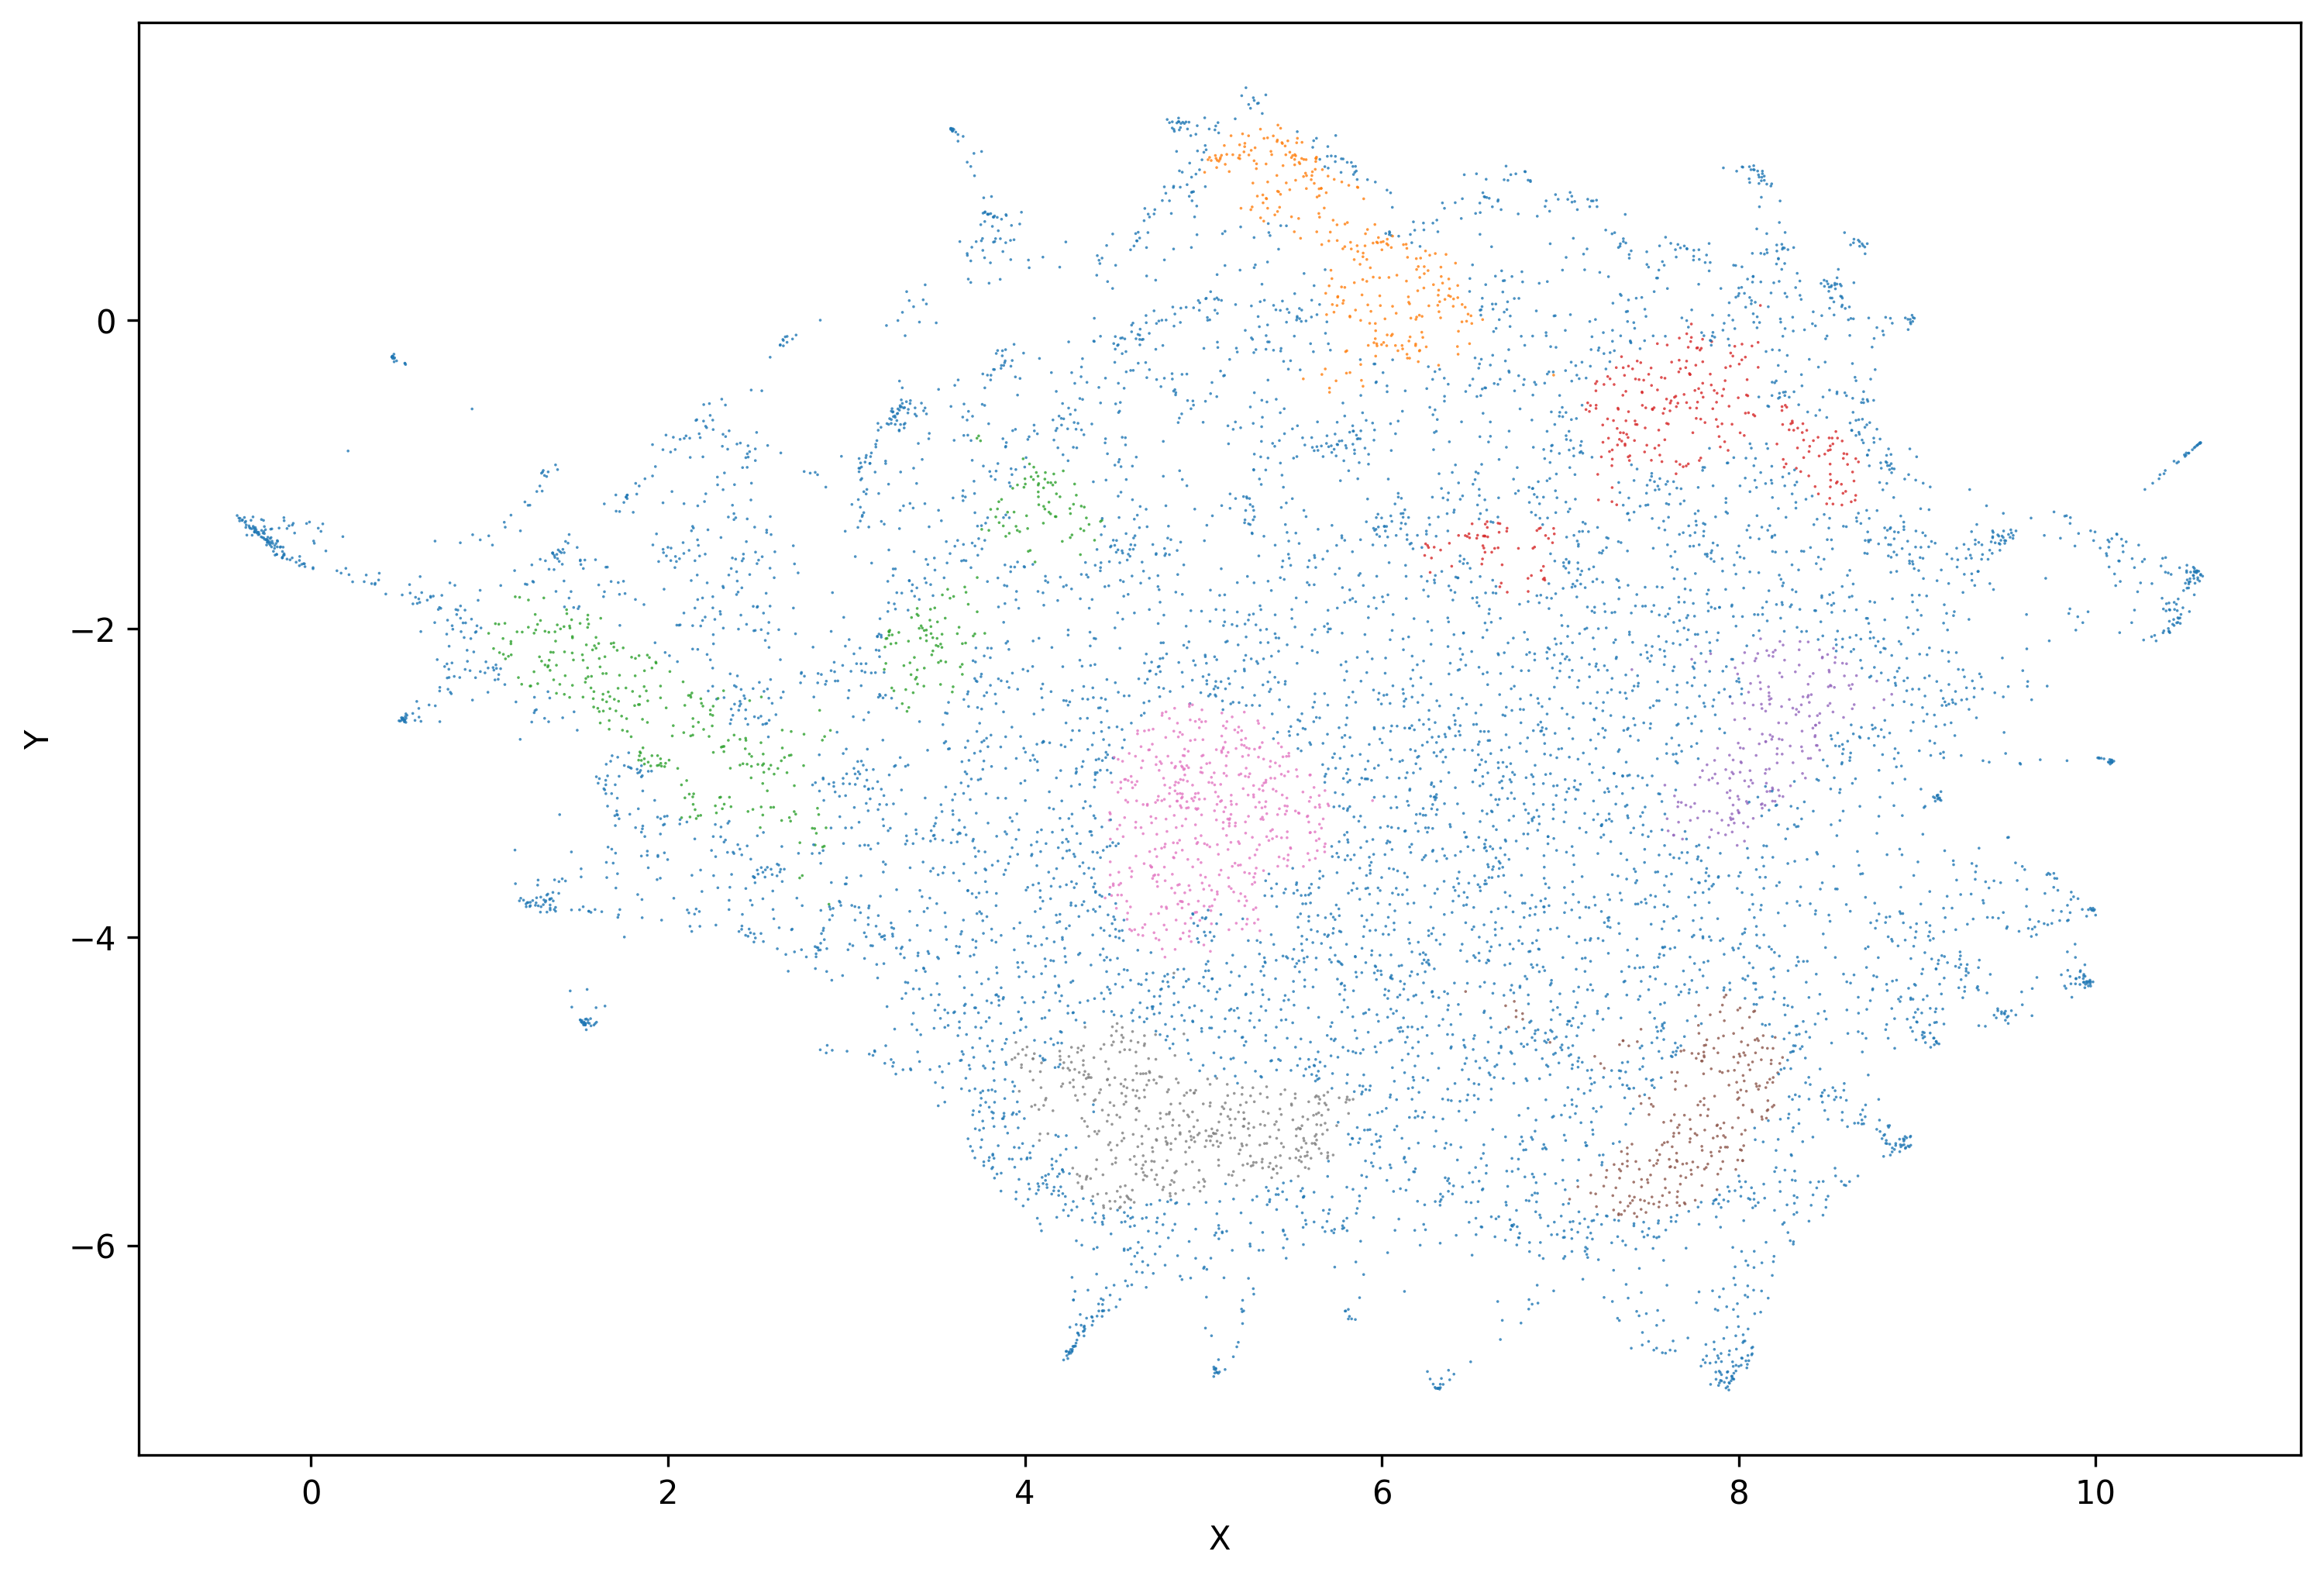

In [3]:
from easy_text_clustering.clusterer import ClusterClassifier
from datasets import load_dataset

ds = load_dataset('openpecha/cleaned_MT_v1.0.3', split='train').select(range(10_000))
cc = ClusterClassifier(embed_model_name='billingsmoore/minilm-bo', embed_device='cuda', summary_create=False)
cc.fit(ds['Source'],clustering_args={'cluster_selection_method':'leaf', 'min_cluster_size':150, 'cluster_selection_epsilon':.175})
cc.show()

## Create Custom Count Vectorizer for Tibetan

In [4]:
import botok
from collections import defaultdict
import numpy as np
from sklearn.feature_extraction.text import TfidfTransformer

class BoCountVectorizer():

    def __init__(self, vocabulary=None, batch_size=5_000):
         
         """
        Custom implementation of CountVectorizer for Tibetan text
        :param vocabulary: Optional predefined vocabulary.
         """

         self.vocabulary = vocabulary
         self.word_to_index = {}
         self.batch_size = batch_size

    def fit(self, corpus):

        """
        Learns the vocabulary from the given corpus.
        :param corpus: List of texts in Tibetan.
        :return: List of results from botok WordTokenizer
        """

        if self.vocabulary is None:

            tokenizer = botok.WordTokenizer()

            if len(corpus) <= self.batch_size:
                tokenized_corpus = [tokenizer.tokenize(elt) for elt in corpus]
                
            else:
                tokenized_corpus = []
                for i in range(0,len(corpus), self.batch_size):
                    tokenized_corpus += [tokenizer.tokenize(elt) for elt in corpus[i:i+self.batch_size]]

            self.vocabulary = sorted(set([token.text for lst in tokenized_corpus for token in lst if (token.pos in ['NOUN', 'VERB'])]))

        self.word_to_index = {word: idx for idx, word in enumerate(self.vocabulary)}

        return tokenized_corpus

    def transform(self, corpus):

        """
        Transforms texts into a document-term matrix.
        :param corpus: List of tokenized texts (each as a list of words).
        :return: NumPy array representing word counts.
        """

        try: 
            assert type(corpus[0][0]) == botok.tokenizers.token.Token
        except:
            tokenizer = botok.WordTokenizer()
            if len(corpus) <= self.batch_size:
                corpus = [tokenizer.tokenize(elt) for elt in corpus]
            else:
                corpus = []
                for i in range(0,len(corpus), self.batch_size):
                    corpus += [tokenizer.tokenize(elt) for elt in corpus[i:i+self.batch_size]]

        matrix = np.zeros((len(corpus), len(self.vocabulary)), dtype=int)

        for doc_idx, text in enumerate(corpus):
            word_counts = defaultdict(int)
            text = [elt.text for elt in text]
            for word in text:
                if word in self.word_to_index:  # Ignore words not in vocabulary
                    word_counts[word] += 1

            # Fill the row in the matrix
            for word, count in word_counts.items():
                matrix[doc_idx, self.word_to_index[word]] = count

        return matrix
    
    def fit_transform(self, corpus):

        """
        Fits the vectorizer and transforms the corpus in one step.
        """

        tokenized_corpus = self.fit(corpus)
        return self.transform(tokenized_corpus)

    def get_vocabulary(self):

        """ Returns the vocabulary (ordered list of words). """
        
        return self.vocabulary

## Use BoCountVectorizer to Label Clusters

In [5]:
# create a summary label for one cluster
def label_cluster(idxs: list, count_vectorizer: BoCountVectorizer, tfidf_res):
    
    average_tfidf_scores = np.asarray(tfidf_res[idxs].mean(axis=0)).flatten()
    top_indices = np.argsort(average_tfidf_scores)[::-1]  # Sort descending
    top_words = [(count_vectorizer.get_vocabulary()[i], average_tfidf_scores[i]) for i in top_indices]
    
    label = '__'.join([word for word, score in top_words[:3]])

    return label

# summarize all of the clusters
def summarize(cc: ClusterClassifier):

    count_vectorizer = BoCountVectorizer()
    matrix = count_vectorizer.fit_transform(cc.texts)
    tfidf_tranformer = TfidfTransformer()
    tfidf_res = tfidf_tranformer.fit_transform(X=matrix)

    cc.cluster_summaries = {}
    for cluster in cc.label2docs.keys():
        idxs = cc.label2docs[cluster]
        label = label_cluster(idxs, count_vectorizer, tfidf_res)
        cc.cluster_summaries[int(cluster)] = label

In [7]:
summarize(cc)
print(cc.cluster_summaries)

Loading Trie... (0s.)


/home/j/Documents/MLotsawa/.venv/lib/python3.12/site-packages/botok/textunits/bostring.py:82: UserWarning: Beware of unexpected results: input string contains the non-expanded char "གྷ", found in "".
  warn(
/home/j/Documents/MLotsawa/.venv/lib/python3.12/site-packages/botok/textunits/bostring.py:82: UserWarning: Beware of unexpected results: input string contains the non-expanded char "བྷ", found in "".
  warn(
/home/j/Documents/MLotsawa/.venv/lib/python3.12/site-packages/botok/textunits/bostring.py:82: UserWarning: Beware of unexpected results: input string contains the non-expanded char "དྷ", found in "".
  warn(
/home/j/Documents/MLotsawa/.venv/lib/python3.12/site-packages/botok/textunits/bostring.py:82: UserWarning: Beware of unexpected results: input string contains the non-expanded char "ཱུ", found in "".
  warn(
/home/j/Documents/MLotsawa/.venv/lib/python3.12/site-packages/botok/textunits/bostring.py:82: UserWarning: Beware of unexpected results: input string contains the non-expan

{-1: 'རེད__བྱེད་__ནང་', 6: 'མེད་པ__མེད་__རང་བཞིན་', 5: 'སྡུག་བསྔལ་__ལུས་__སེམས་ཅན་', 4: 'ཆོས་__སངས་རྒྱས་__དོན་', 0: 'རེད__ཁོས་__སོང་', 1: 'བྱེད་__ཚོས་__ཡོད', 3: 'སློབ་དཔོན་__བླ་མ་__རྒྱལ་པོ་', 2: 'ནང་__ཡོད__རེད'}


## Plot Results

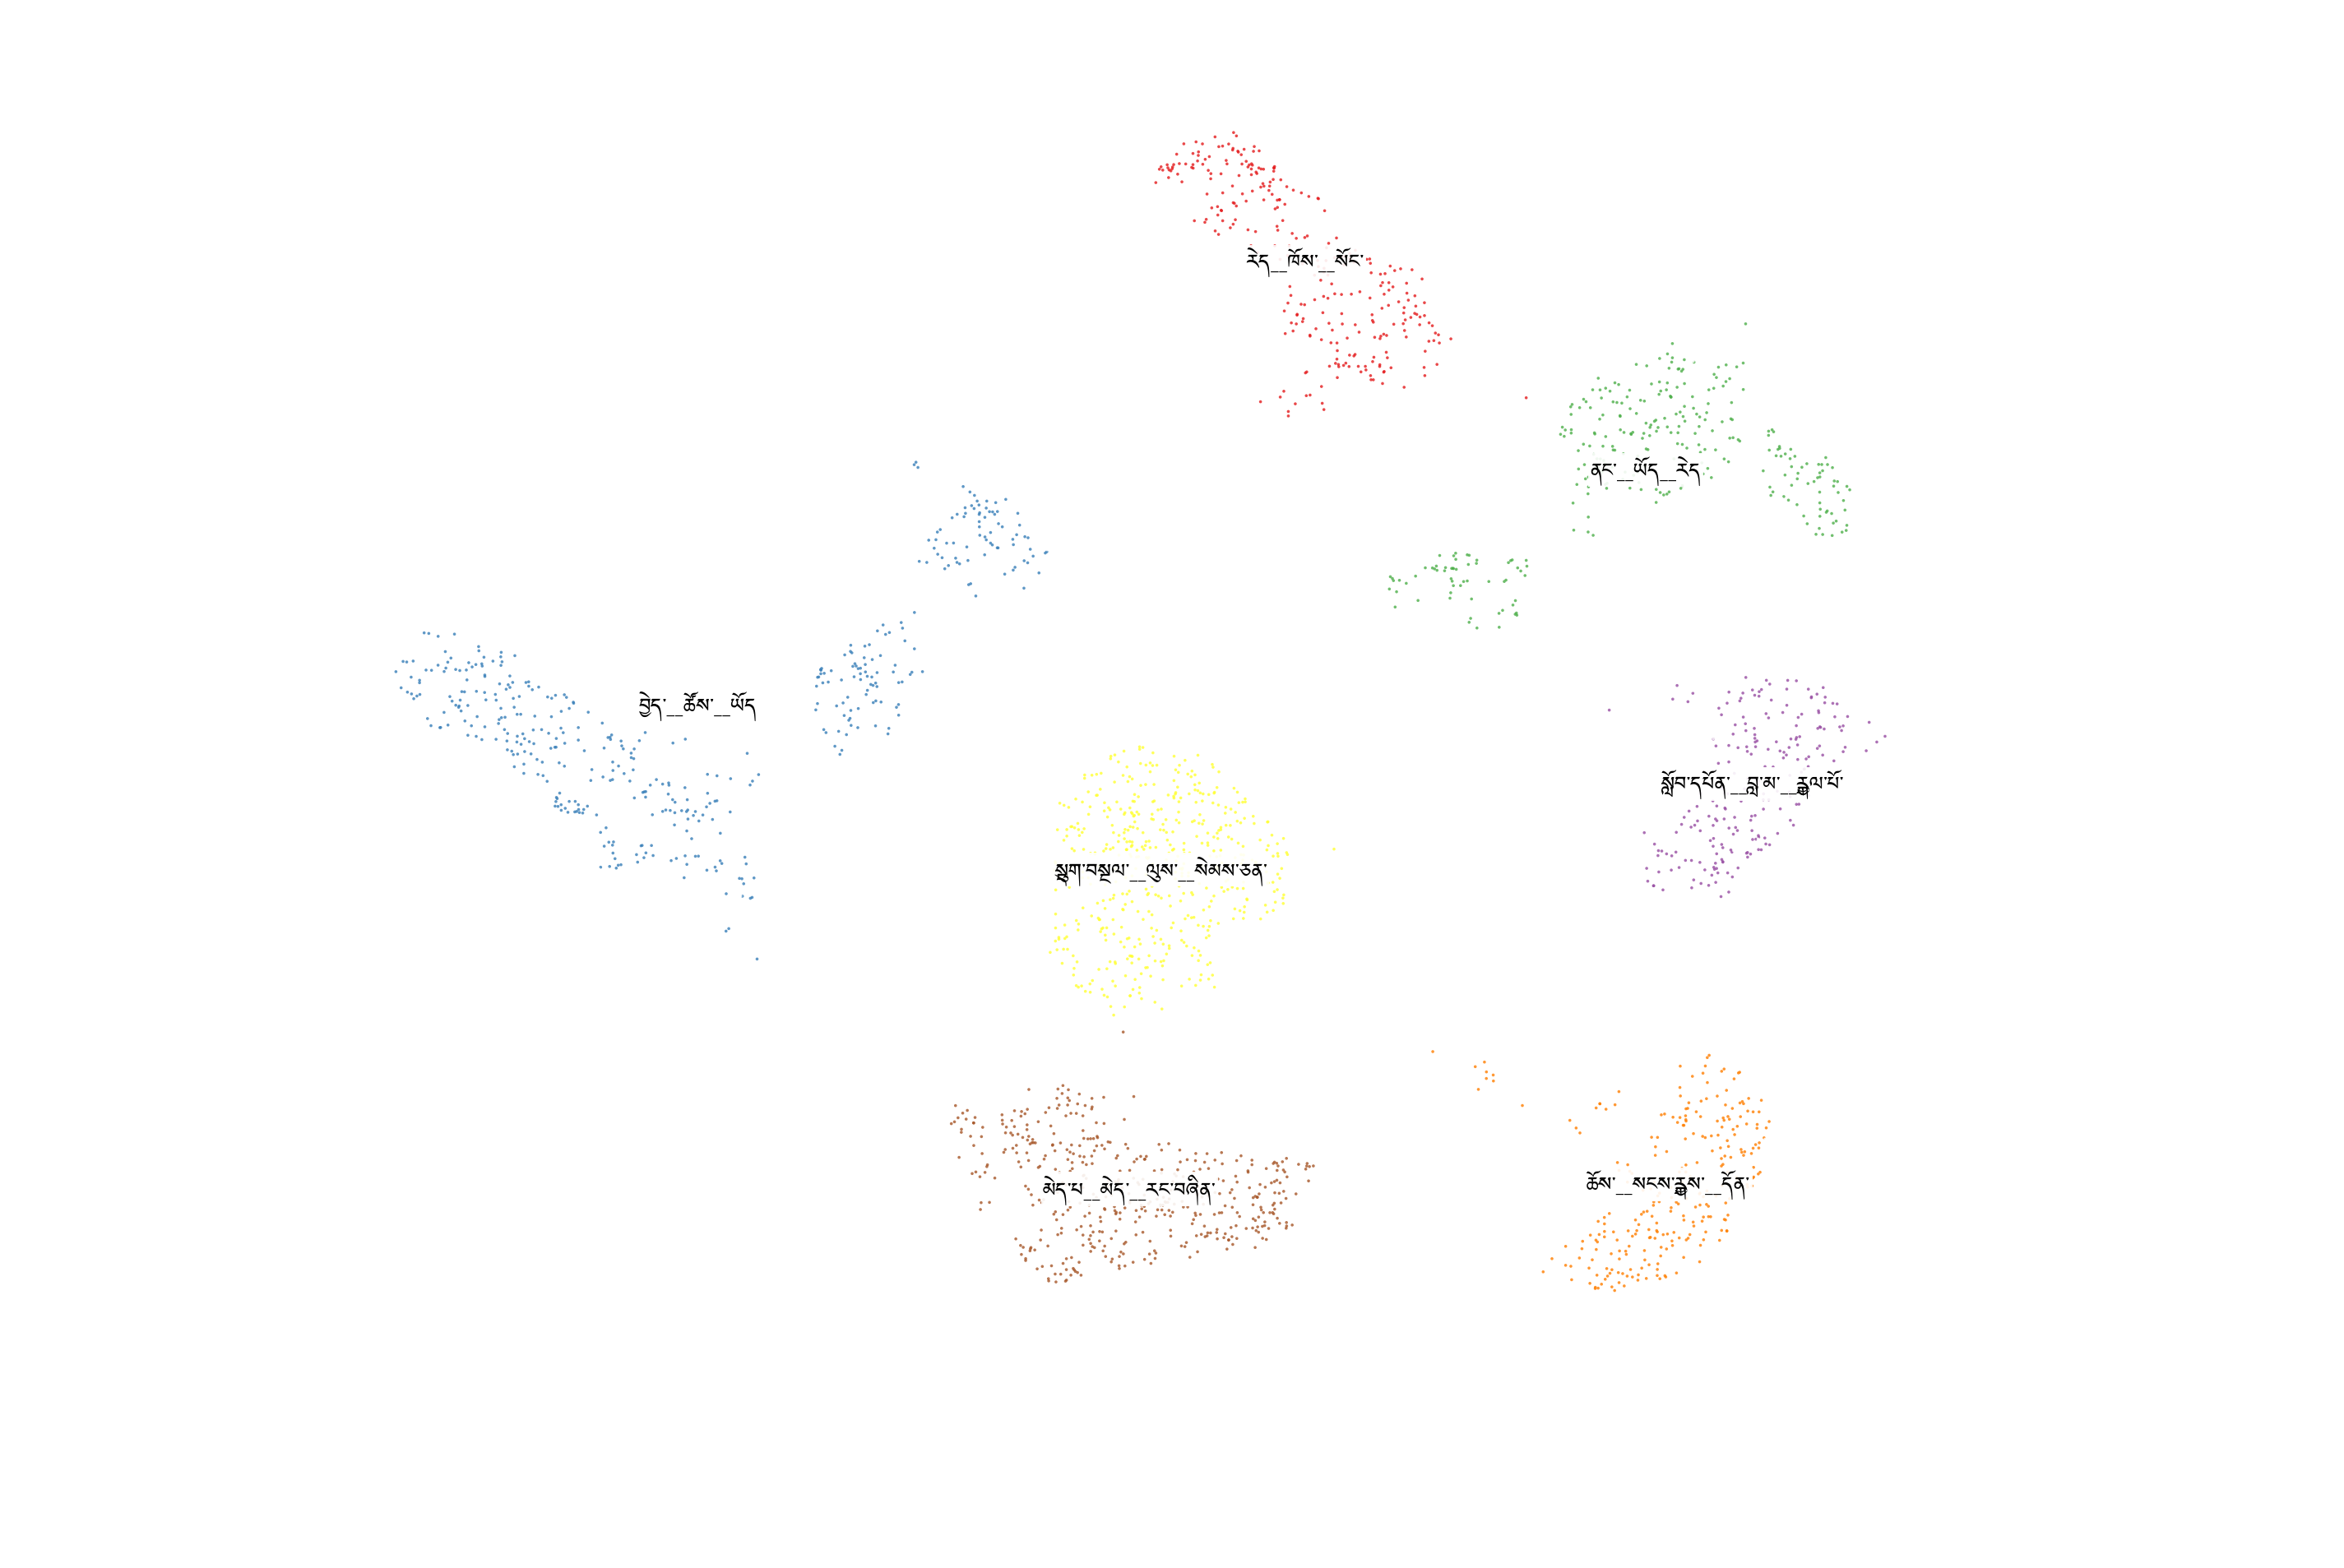

In [12]:
import pandas as pd
import textwrap
import matplotlib.pyplot as plt
from pathlib import Path

# Load Tibetan font
fpath = Path("DDC_Uchen.ttf")


df = pd.DataFrame(
                data={
                    "X": cc.projections[:, 0],
                    "Y": cc.projections[:, 1],
                    "labels": cc.cluster_labels,
                    "content_display": [
                        textwrap.fill(txt[:1024], 64) for txt in cc.texts
                    ],
                }
            )

fig, ax = plt.subplots(figsize=(12, 8), dpi=300)
#df["color"] = df["labels"].apply(lambda x: "C0" if x == -1 else f"C{(x % 9) + 1}")

colors = plt.get_cmap("Set1").colors  # "Set1" provides vivid colors
df["color"] = df["labels"].apply(lambda x: "white" if x == -1 else colors[x % len(colors)])


df.plot(
        kind="scatter",
        x="X",
        y="Y",
        s=0.75,
        alpha=0.8,
        linewidth=0,
        color=df["color"],
        ax=ax,
        colorbar=False,
    )

for label in cc.cluster_summaries.keys():
                if label == -1:
                    continue  # Skip the outlier cluster
                summary = cc.cluster_summaries[label]
                position = cc.cluster_centers[label]
                t = ax.text(
                    position[0],
                    position[1],
                    summary,
                    horizontalalignment='center',
                    verticalalignment='center',
                    fontsize=6,
                    font=fpath
                )
                # Set the background for the text annotation for better readability
                t.set_bbox(dict(facecolor='white', alpha=0.9, linewidth=0, boxstyle='square,pad=0.1'))

# Turn off the axis for a cleaner plot
ax.set_axis_off()

In [9]:
cc.save('poc-cc')